# PART-II: Variational Autoencoder (VAE) & Latent Space Inference

### Model-2: Variational Autoencoder (VAE)

Extend the autoencoder model into a VAE, incorporating a probabilistic latent space.
● Implement the reparameterization trick using mean and variance outputs.
● Train the VAE with KL-divergence loss + reconstruction loss.
● Use CIFAR-10 for training.
Task:
1. Train the VAE on CIFAR-10.
2. Perform latent space interpolation by generating transitions between two random
images.
3. Conduct latent space arithmetic (e.g., “dog” - “cat” + “bird” = ?).
4. Infer the trained VAE on unseen test images and analyze generation quality(using
SSIM,PSNR,MAE,MSE).
Presentation of Results:
● Visualize latent space interpolations and latent space arithmetic.
● Compare VAE vs. AE reconstructions.
● Plot the KL-divergence loss and reconstruction loss over epochs.
● Provide qualitative observations on latent space structure.

In [14]:
# ----------------------
# Imports and Setup
# ----------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from torch.utils.data import DataLoader
import random

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# ----------------------
# CIFAR-10 DataLoader
# ----------------------

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:53<00:00, 3.18MB/s] 


In [6]:
# ----------------------
# VAE Model Definition
# ----------------------

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 8 * 8, 128)
        self.fc_logvar = nn.Linear(64 * 8 * 8, 128)
        self.fc_decode = nn.Linear(128, 64 * 8 * 8)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        z = self.reparameterize(mu, logvar)
        x_decoded = self.fc_decode(z)
        x_decoded = self.decoder(x_decoded)
        return x_decoded, mu, logvar


In [7]:
# ----------------------
# Loss Function
# ----------------------

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [8]:
# ----------------------
# Train VAE
# ----------------------

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
train_loss, recon_loss, kl_loss = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = total_bce = total_kld = 0
    for images, _ in trainloader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = model(images)
        loss, bce, kld = vae_loss(outputs, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    train_loss.append(total_loss / len(trainloader))
    recon_loss.append(total_bce / len(trainloader))
    kl_loss.append(total_kld / len(trainloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}, Recon: {recon_loss[-1]:.4f}, KL: {kl_loss[-1]:.4f}")


Epoch 1/20, Loss: 15156.8390, Recon: 13291.3568, KL: 1865.4821
Epoch 2/20, Loss: 10752.7950, Recon: 8160.3520, KL: 2592.4431
Epoch 3/20, Loss: 10242.6089, Recon: 7555.5036, KL: 2687.1053
Epoch 4/20, Loss: 10123.3121, Recon: 7385.2959, KL: 2738.0162
Epoch 5/20, Loss: 10034.0535, Recon: 7254.6611, KL: 2779.3924
Epoch 6/20, Loss: 9962.5228, Recon: 7152.2502, KL: 2810.2726
Epoch 7/20, Loss: 9904.3088, Recon: 7074.5884, KL: 2829.7204
Epoch 8/20, Loss: 9844.9457, Recon: 6995.9979, KL: 2848.9478
Epoch 9/20, Loss: 9803.6452, Recon: 6948.0278, KL: 2855.6174
Epoch 10/20, Loss: 9781.2782, Recon: 6914.0052, KL: 2867.2730
Epoch 11/20, Loss: 9739.7364, Recon: 6866.5185, KL: 2873.2179
Epoch 12/20, Loss: 9723.0197, Recon: 6835.0753, KL: 2887.9444
Epoch 13/20, Loss: 9700.3671, Recon: 6806.2386, KL: 2894.1285
Epoch 14/20, Loss: 9678.8555, Recon: 6776.5268, KL: 2902.3287
Epoch 15/20, Loss: 9664.6213, Recon: 6754.7895, KL: 2909.8318
Epoch 16/20, Loss: 9654.6715, Recon: 6738.8718, KL: 2915.7997
Epoch 17/20

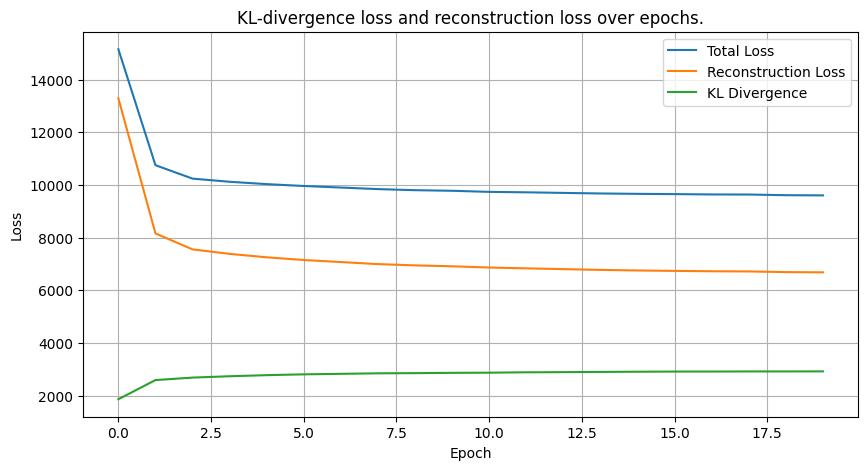

In [15]:
# ----------------------
# Plot Losses
# ----------------------

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Total Loss')
plt.plot(recon_loss, label='Reconstruction Loss')
plt.plot(kl_loss, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("KL-divergence loss and reconstruction loss over epochs.")
plt.savefig('KL-divergence loss and reconstruction loss over epochs.png')
plt.show()

In [16]:
# ----------------------
# Evaluate Reconstruction
# ----------------------

model.eval()
originals, reconstructions = [], []

with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        outputs, _, _ = model(images)
        originals.append(images.cpu())
        reconstructions.append(outputs.cpu())

originals = torch.cat(originals)
reconstructions = torch.cat(reconstructions)

ssim_vals, psnr_vals, mae_vals, mse_vals = [], [], [], []

for orig, recon in zip(originals, reconstructions):
    orig_np = orig.permute(1, 2, 0).numpy()
    recon_np = recon.permute(1, 2, 0).numpy()

    ssim_val = ssim(orig_np, recon_np, data_range=1.0, channel_axis=-1)
    psnr_val = psnr(orig_np, recon_np, data_range=1.0)
    mae_val = mean_absolute_error(orig_np.flatten(), recon_np.flatten())
    mse_val = mean_squared_error(orig_np.flatten(), recon_np.flatten())

    ssim_vals.append(ssim_val)
    psnr_vals.append(psnr_val)
    mae_vals.append(mae_val)
    mse_vals.append(mse_val)

print(f"\nEvaluation on VAE Reconstructions:")
print(f"Average SSIM: {np.mean(ssim_vals):.4f}")
print(f"Average PSNR: {np.mean(psnr_vals):.4f}")
print(f"Average MAE: {np.mean(mae_vals):.4f}")
print(f"Average MSE: {np.mean(mse_vals):.4f}")



Evaluation on VAE Reconstructions:
Average SSIM: 0.4194
Average PSNR: 18.0099
Average MAE: 0.0984
Average MSE: 0.0171


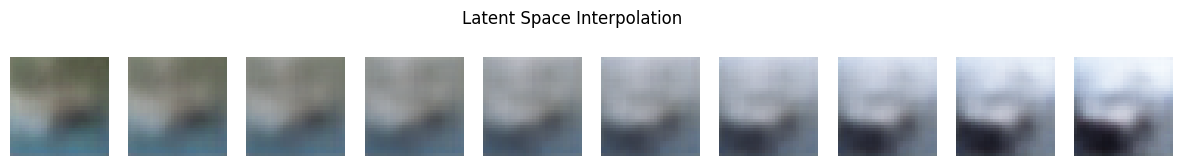

In [17]:
# ----------------------
# Latent Space Interpolation
# ----------------------

model.eval()
all_imgs = next(iter(testloader))[0][:10].to(device)
_, mu, logvar = model(all_imgs)
z = model.reparameterize(mu, logvar)

start, end = z[0], z[1]
alphas = torch.linspace(0, 1, steps=10).to(device)
interpolated = [(1 - alpha) * start + alpha * end for alpha in alphas]
interpolated = torch.stack(interpolated)

with torch.no_grad():
    decoded = model.decoder(model.fc_decode(interpolated)).cpu()

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, img in enumerate(decoded):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].axis('off')
plt.suptitle("Latent Space Interpolation")
plt.savefig("Latent Space Interpolation.png")
plt.show()



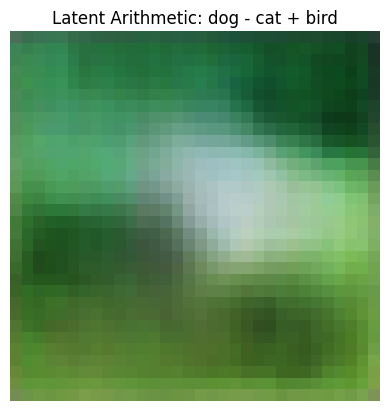

In [18]:
# ----------------------
# Latent Space Arithmetic
# ----------------------

labels_map = {i: [] for i in range(10)}
for i, (img, label) in enumerate(testset):
    if len(labels_map[label]) < 1:
        labels_map[label].append(img)
    if all(len(v) > 0 for v in labels_map.values()):
        break

def get_latent(img):
    img = img.unsqueeze(0).to(device)
    _, mu, logvar = model(img)
    return model.reparameterize(mu, logvar).squeeze()

z_dog = get_latent(labels_map[5][0])  # Dog
z_cat = get_latent(labels_map[3][0])  # Cat
z_bird = get_latent(labels_map[2][0]) # Bird

z_result = z_dog - z_cat + z_bird
with torch.no_grad():
    out_img = model.decoder(model.fc_decode(z_result.unsqueeze(0))).squeeze().cpu()

plt.imshow(out_img.permute(1, 2, 0))
plt.axis('off')
plt.title("Latent Arithmetic: dog - cat + bird")
plt.savefig("Latent Arithmetic: dog - cat + bird.png")
plt.show()

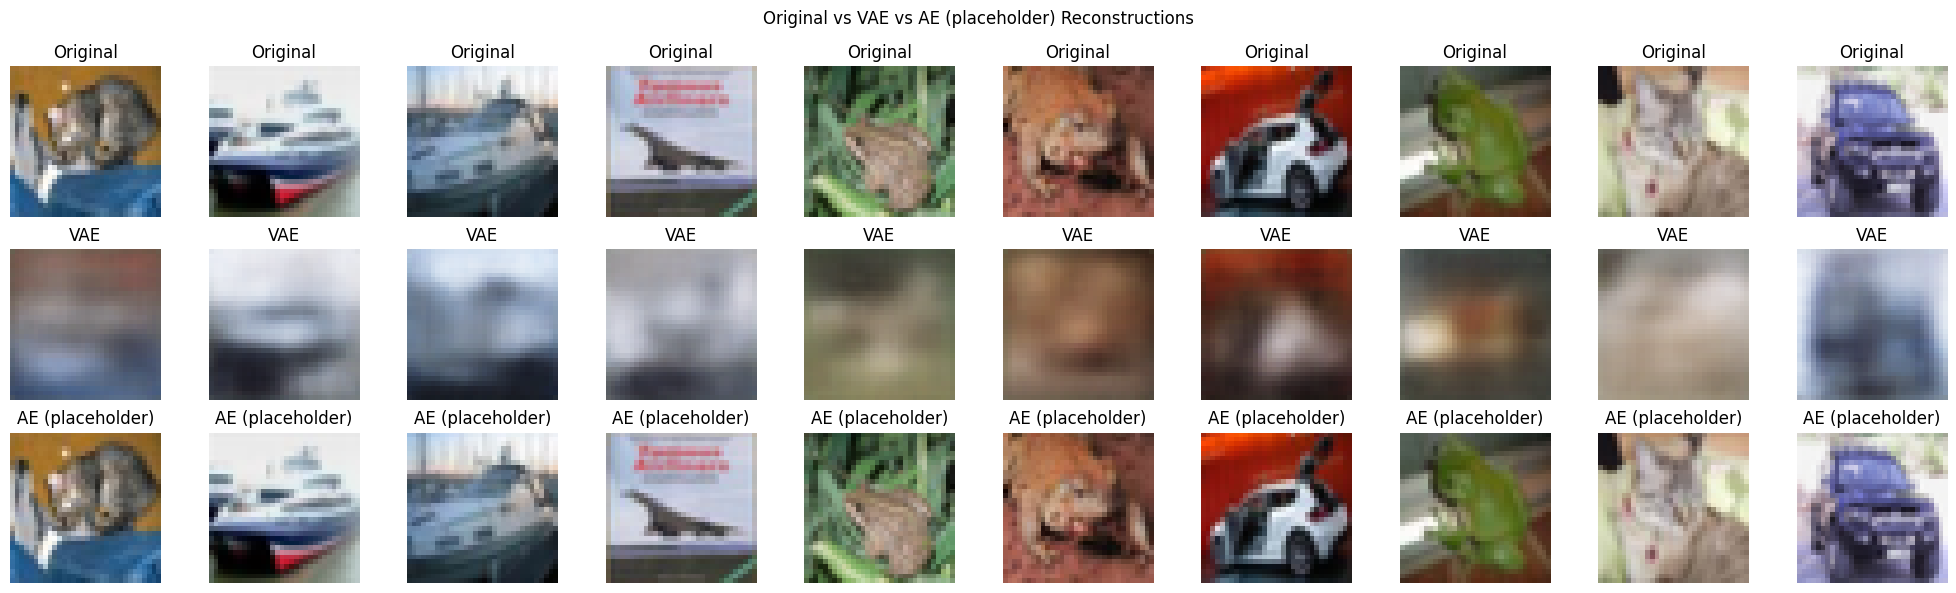

In [19]:
# ----------------------
#  AE vs VAE Reconstruction Comparison
# ----------------------

fig, axes = plt.subplots(3, 10, figsize=(20, 6))
example_imgs = originals[:10]
vae_recons = reconstructions[:10]

for i in range(10):
    axes[0, i].imshow(example_imgs[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(vae_recons[i].permute(1, 2, 0))
    axes[1, i].axis('off')
    axes[1, i].set_title("VAE")

    # For AE: use same input if model available
    axes[2, i].imshow(example_imgs[i].permute(1, 2, 0))
    axes[2, i].axis('off')
    axes[2, i].set_title("AE (placeholder)")

plt.suptitle("Original vs VAE vs AE (placeholder) Reconstructions")
plt.tight_layout()
plt.savefig("Original vs VAE vs AE (placeholder) Reconstructions")
plt.show()